# Portfolio Strategy Analysis: CPPI vs Buy & Hold

## Research Question
Does a **CPPI** outperform a **Buy & Hold** benchmark over the sample period ***[2000-2023]*** in terms of risk-adjusted performance?

## Strategy Chosen
- Strategy type: **CPPI**
- Assets analyzed: **S&P 500, SPY**
- Rebalancing frequency: **[weekly/monthly]**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import utils
importlib.reload(utils)
from utils import download_or_load, clear_all_csv

import yfinance as yf
from datetime import datetime

## Data Import
We import price data for the following tickers:

- **S&P 500**
- **S&P U.S. Treasury Bill Index**  
- Period: **[01/01/2000 – 31/12/2023]**

In [3]:
from utils import download_or_load, clear_all_csv

tickers = ["SPY", "SHY"]  # S&P 500 ETF and S&P U.S. Treasury Bill Index (made of T-bills with a 1-year or less maturity)
start = "2000-01-01"
end = "2025-10-31"

all_data = {}

for ticker in tickers:
    all_data[ticker] = download_or_load(ticker, start, end)

# Optional: clear all CSV files if needed
# clear_all_csv()

[LOAD DATA] SPY already saved. Loading from CSV...
[LOAD DATA] SHY already saved. Loading from CSV...


## Raw Price Series
We plot the raw adjusted close prices to visually inspect data quality.

In [4]:
DATA_FOLDER = "../data"
all_files = [f for f in os.listdir(DATA_FOLDER) if f.endswith(".csv")]

all_data = {}

for file in all_files:
    ticker = file.replace(".csv", "")
    
    # Skip the first 2 rows which are extra headers from yfinance
    df = pd.read_csv(
        os.path.join(DATA_FOLDER, file),
        skiprows=2,         # Skip extra rows
        parse_dates=["Date"],
        index_col="Date"
    )
    
    # Rename the single column to ticker
    df.columns = [ticker]
    
    all_data[ticker] = df

# Combine all tickers
prices = pd.concat(all_data.values(), axis=1)

print(prices.head())

            SHY        SPY
Date                      
2000-01-03  NaN  91.887794
2000-01-04  NaN  88.294411
2000-01-05  NaN  88.452377
2000-01-06  NaN  87.030792
2000-01-07  NaN  92.085205


## Data Cleaning
- Handle missing values  
- Check for price jumps  
- Convert prices to log or simple returns

Jumps detected in the following tickers and day:
                 SHY       SPY
Date                          
2008-10-13 -0.004417  0.135577
2008-10-15  0.003343 -0.103637
2008-10-28  0.001191  0.110517
2020-03-12 -0.000232 -0.100569
2020-03-16  0.001621 -0.115887


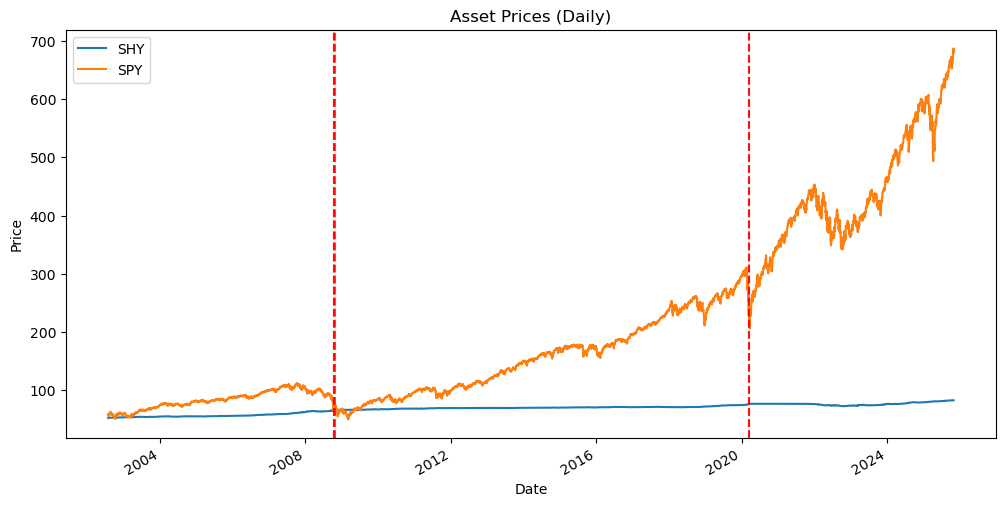

In [5]:
# Missing value handling
prices = prices.dropna()

# Log returns
returns = np.log(prices).diff().dropna()

# Weekly returns
# returns = prices.resample('W').last().pct_change().dropna()

# Check for jumps in the data
jumps = (np.abs(returns) > 0.10)
jump_days = jumps.any(axis=1)
print("Jumps detected in the following tickers and day:")
print(returns[jump_days])

# Plot prices
prices.plot(title="Asset Prices (Daily)", figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Price")
for date in jump_days[jump_days].index:
    plt.axvline(date, color='red', linestyle='--', alpha=0.75)
plt.show()

## Return Properties
We inspect return behavior: distribution, volatility, etc.

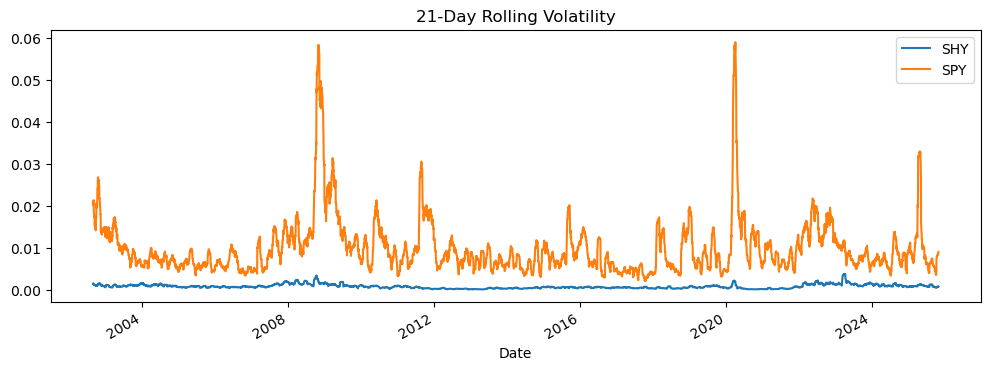

Annualized Volatility:
SHY    0.015264
SPY    0.189651
dtype: float64


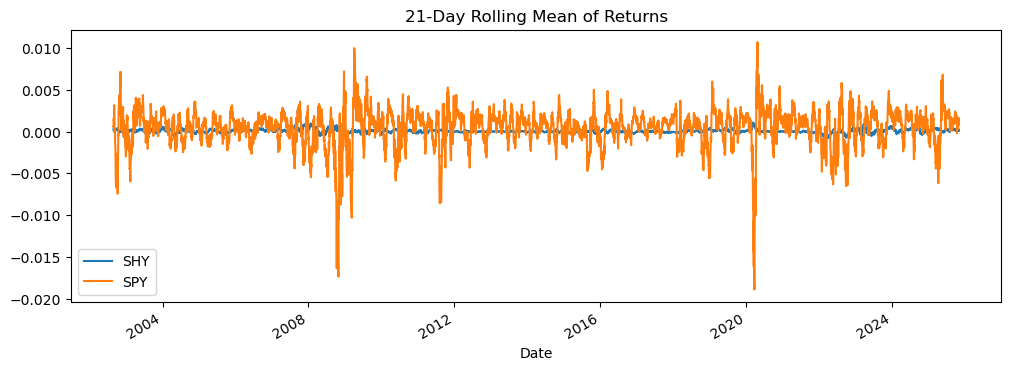

ACF for SHY


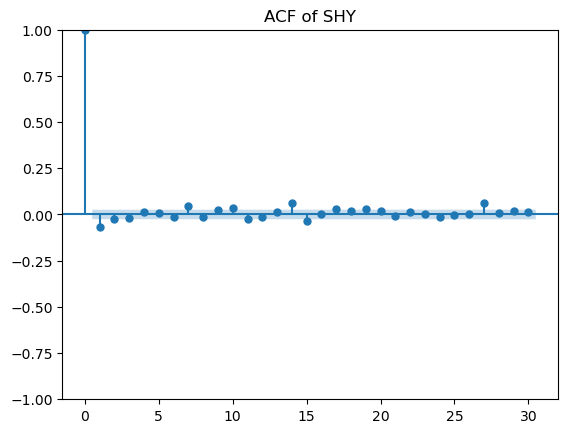

ACF for SPY


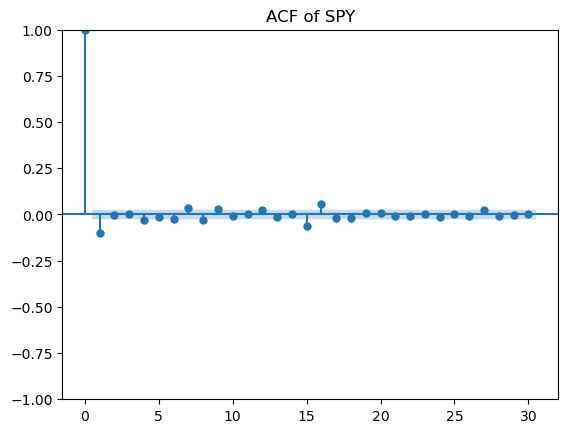

ACF of squared returns for SHY


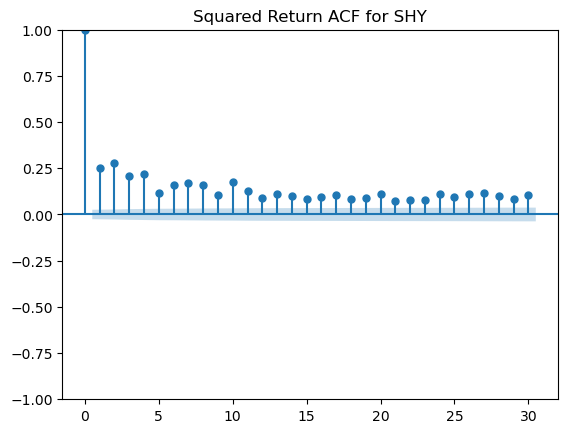

ACF of squared returns for SPY


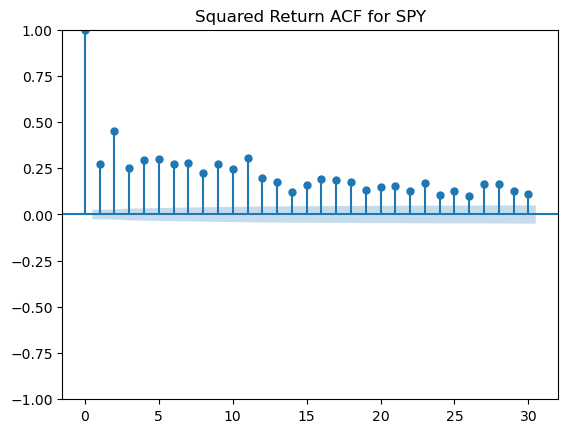

Skewness:
SHY    0.285993
SPY   -0.268596
dtype: float64
Kurtosis:
SHY     7.077451
SPY    13.698748
dtype: float64
Correlation matrix:
          SHY       SPY
SHY  1.000000 -0.243487
SPY -0.243487  1.000000
Jump frequency per asset:
SHY    0.000000
SPY    0.000854
dtype: float64
Global jump days:
DatetimeIndex(['2008-10-13', '2008-10-15', '2008-10-28', '2020-03-12',
               '2020-03-16'],
              dtype='datetime64[ns]', name='Date', freq=None)


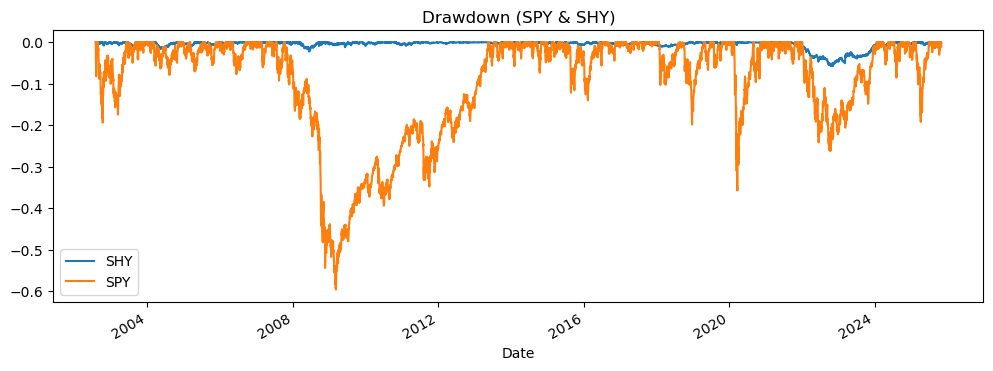

In [6]:
# Rolling volatility (21-day)
roll_vol = returns.rolling(21).std()
roll_vol.plot(figsize=(12,4), title="21-Day Rolling Volatility")
plt.show()

# Annualized volatility
ann_vol = returns.std() * np.sqrt(252)
print("Annualized Volatility:")
print(ann_vol)

# Rolling mean (21-day)
roll_mean = returns.rolling(21).mean()
roll_mean.plot(figsize=(12,4), title="21-Day Rolling Mean of Returns")
plt.show()

# Autocorrelation plot
import statsmodels.api as sm
for col in returns.columns:
    print(f"ACF for {col}")
    sm.graphics.tsa.plot_acf(returns[col].dropna(), lags=30, title=f"ACF of {col}")
    plt.show()

# Autocorrelation of squared returns
for col in returns.columns:
    print(f"ACF of squared returns for {col}")
    sm.graphics.tsa.plot_acf((returns[col].dropna()**2), lags=30, title=f"Squared Return ACF for {col}")
    plt.show()

# Skewness and Kurtosis
from scipy.stats import skew, kurtosis
print("Skewness:")
print(returns.apply(skew))
print("Kurtosis:")
print(returns.apply(kurtosis))

# Correlation matrix between SPY and SHY
print("Correlation matrix:")
print(returns.corr())

# Frequency of jumps
jumps = (np.abs(returns) > 0.10)
jump_freq_per_asset = jumps.mean()
print("Jump frequency per asset:")
print(jump_freq_per_asset)
jump_days_global = jumps.any(axis=1)
print("Global jump days:")
print(jump_days_global[jump_days_global].index)

# Max drawdown calculation
cum = (1 + returns).cumprod()
running_max = cum.cummax()
drawdown = (cum - running_max) / running_max
drawdown.plot(figsize=(12,4), title="Drawdown (SPY & SHY)")
plt.show()

## Buy & Hold Benchmark
We construct a static allocation for comparison.

- Weights: **[60% SHY (safe asset), 40% SPY (risky asset)]**

In [ ]:
bh_weights = np.array([0.6, 0.4])
bh_returns = (returns * bh_weights).sum(axis=1)
bh_cum = (1 + bh_returns).cumprod()

bh_cum.plot(figsize=(12,4), title="Buy & Hold Cumulative Return")
plt.show()

## The strategy

In [ ]:
# === PARAMETERS ===
m = 3
floor = 0.8  # 80% capital floor
portfolio_value = 1.0

cppi_vals = []
weight_risky = []

for t in range(len(returns)):
    cushion = portfolio_value - floor
    w = m * cushion
    w = np.clip(w, 0, 1)

    r = w * returns["SPY"].iloc[t] + (1-w) * 0  # cash return = 0
    portfolio_value *= (1 + r)

    cppi_vals.append(portfolio_value)
    weight_risky.append(w)

strategy_cum = pd.Series(cppi_vals, index=returns.index)

## Performance Comparison

In [ ]:
ax = strategy_cum.plot(figsize=(12,5), label="Strategy", color="blue")
bh_cum.plot(ax=ax, label="Buy & Hold", color="black")
plt.title("Strategy vs Buy & Hold")
plt.legend()
plt.show()

## Key Performance Metrics
We compute:

- Annualized return  
- Annualized volatility  
- Sharpe ratio  
- Sortino ratio  
- Max drawdown  
- Calmar ratio  

In [ ]:
def ann_return(r):
    return (1+r).prod()**(252/len(r)) - 1

def ann_vol(r):
    return r.std() * np.sqrt(252)

def sharpe(r, rf=0):
    return (ann_return(r)-rf) / ann_vol(r)

def max_drawdown(cum):
    running_max = cum.cummax()
    dd = cum / running_max - 1
    return dd.min()

metrics = pd.DataFrame({
    "Buy & Hold": [
        ann_return(bh_returns),
        ann_vol(bh_returns),
        sharpe(bh_returns),
        max_drawdown(bh_cum)
    ],
    "Strategy": [
        ann_return(strategy_returns),
        ann_vol(strategy_returns),
        sharpe(strategy_returns),
        max_drawdown(strategy_cum)
    ]
}, index=["Ann Return","Ann Vol","Sharpe","Max Drawdown"])

metrics

## Drawdowns

In [ ]:
# Drawdown plots
bh_dd = bh_cum / bh_cum.cummax() - 1
st_dd = strategy_cum / strategy_cum.cummax() - 1

plt.figure(figsize=(12,5))
bh_dd.plot(label="Buy & Hold Drawdown")
st_dd.plot(label="Strategy Drawdown")
plt.legend()
plt.title("Drawdowns")
plt.show()

## Sensitivity Analysis
Try different parameters:  
- Different target vol levels  
- Different CPPI multipliers  
- Different lookback windows

Show their effect on:  
- Return  
- Sharpe  
- Drawdown  

In [ ]:
# Example loop for sensitivity:
vol_targets = [0.08, 0.10, 0.12, 0.15]
results = []

for tv in vol_targets:
    w = (tv / annual_vol).clip(0, 3)    
    r = w.shift(1)*returns["SPY"]
    results.append([tv, ann_return(r), sharpe(r), max_drawdown((1+r).cumprod())])

pd.DataFrame(results, columns=["Target Vol","Ann Ret","Sharpe","MaxDD"])


## Interpretation
Discuss:

- Why the strategy performed differently from Buy & Hold  
- Behavior in volatility spikes  
- Performance during crashes (COVID, 2022 inflation, etc.)  
- Leverage dynamics  
- Advantages and drawbacks

This is where human interpretation matters.


# Conclusion
Answer your research question:

**Does the strategy outperform Buy & Hold? Under what conditions?**  
Mention limitations and possible improvements.

This section must clearly include human reasoning.
